In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
import csv
import scipy
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import time

# Modelo de Red Profunda

Para compilar este archivo que presenta el modelo de Red Profunda para la clasificación de emociones se debe descargar previamente el siguiente Dataset: [Dataset de Speech Emotions](https://www.kaggle.com/datasets/uldisvalainis/audio-emotions/download?datasetVersionNumber=1 ), que contiene 12.782 audios distribuidos en 7 categorias que son: Angry (0) Disgusted(1), Fearful(2), Happy(3), Neutral(4), Sad(5) y Surprised(6). 

El modelo esta compuesto por 5 capas: 1 entrada, 1 salida y 3 capas ocultas.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/'ML Proyecto'

/content/drive/MyDrive/ML Proyecto


In [5]:
# Poner aqui la ruta del dataset de speech emotions previamente cargado
DATASET = './Dataset/Emotions' 

In [6]:
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=16000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return waveform, desired_sample_rate

In [7]:
labels = {
    'Angry': 0,
    'Disgusted': 1,
    'Fearful': 2,
    'Happy': 3,
    'Neutral': 4,
    'Sad': 5,
    'Suprised': 6
}

In [8]:
# remueve los silencios de las grabaciones
def remove_silence(signal, threshold=0.005):
    """
    Remove silence at the beginning and at the end of the signal
    """
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    for j in range(len(signal)-1, 0, -1):
        if np.abs(signal[j]) > threshold:
            break
    return signal[i:j]

In [9]:
wav_path = f'{DATASET}/Angry/03-01-05-01-01-01-01.wav'
wav_data, sample_rate = librosa.load(wav_path)
print(f'Original sample rate: {sample_rate} Hz')

# Asegurarse que la muestra este en el rango de 16 kHz y calcular la longitud de las muestras
waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
duration = len(waveform)/sample_rate

# Mostrar información básica que contiene el audio
print(f'Model Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(waveform)}')

# Escuchar el audio 
Audio(waveform, rate=sample_rate)

Original sample rate: 22050 Hz
Model Sample rate: 16000 Hz
Total duration: 3.87s
Size of the input: 61929


In [10]:
lst = [] # Obtención de los datos
i = 0
start_time = time.time()
for subdir, dirs, files in os.walk(DATASET):
  print(subdir)
  print(i)
  for file in files:
    X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
    X = remove_silence(X)
    if len(X) == 0:
      continue

    mfcc_values = librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=4096, hop_length=256, n_mfcc=128).T 
    mfccs_mean = np.mean(mfcc_values, axis=0) # media en los coeficientes
    mfccs_std = np.std(mfcc_values, axis=0) # Desviación estandar en los coeficientes
    mfccs = np.concatenate((mfccs_mean, mfccs_std), axis=0)
    lst.append((mfccs, i))

  if files:
    i = i + 1
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

./Dataset/Emotions
0
./Dataset/Emotions/Angry
0
--- Data loaded. Loading time: 230.33863997459412 seconds ---
./Dataset/Emotions/Disgusted
1
--- Data loaded. Loading time: 412.6232831478119 seconds ---
./Dataset/Emotions/Fearful
2
--- Data loaded. Loading time: 634.6415429115295 seconds ---
./Dataset/Emotions/Happy
3
--- Data loaded. Loading time: 869.1750376224518 seconds ---
./Dataset/Emotions/Neutral
4
--- Data loaded. Loading time: 1034.8420104980469 seconds ---
./Dataset/Emotions/Sad
5
--- Data loaded. Loading time: 1294.144755601883 seconds ---
./Dataset/Emotions/Suprised
6
--- Data loaded. Loading time: 1369.0580823421478 seconds ---


# Clasificador

In [11]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [12]:
# Creando X e y: zip crea una lista de todos los primeros elementos y una lista de todos los segundos elementos.
X, y = zip(*lst)
import numpy as np
X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Como siempre, necesitamos expandir las dimensiones, para que podamos ingresar los datos a NN.
x_trainn = np.expand_dims(X_train, axis=2) 
x_testnn = np.expand_dims(X_test, axis=2)
x_valnn = np.expand_dims(X_val, axis=2)

print("Tamaño de Training: ", x_trainn.shape)
print("Tamaño de Testing: ", x_testnn.shape)
print("Tamaño de Validation: ", x_valnn.shape)

Tamaño de Training:  (7678, 256, 1)
Tamaño de Testing:  (2559, 256, 1)
Tamaño de Validation:  (2560, 256, 1)


In [13]:
model = keras.Sequential([

        # Capa de entrada
        keras.layers.Flatten(input_shape=(256, 1)),
        # Primera capa densa
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)), # Regularizador para aplicar una penalización en el kernel de la capa, L2 para que el modelo generalice un poco mejor
        keras.layers.Dropout(0.3),
        # Segunda capa densa
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.3),
        # Tercera capa densa
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.2),
        # Capa de salida
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
optimiser = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [14]:
history = model.fit(x_trainn, y_train, batch_size=64, epochs=2000, validation_data=(x_valnn, y_val))

Epoch 1/2000
120/120 [==============================] - 4s 7ms/step - loss: 52.4304 - accuracy: 0.1340 - val_loss: 34.3333 - val_accuracy: 0.1715
Epoch 2/2000
120/120 [==============================] - 1s 5ms/step - loss: 46.7173 - accuracy: 0.1390 - val_loss: 32.7935 - val_accuracy: 0.1867
Epoch 3/2000
120/120 [==============================] - 1s 5ms/step - loss: 43.0934 - accuracy: 0.1407 - val_loss: 31.4423 - val_accuracy: 0.1906
Epoch 4/2000
120/120 [==============================] - 0s 4ms/step - loss: 40.0478 - accuracy: 0.1499 - val_loss: 30.0680 - val_accuracy: 0.1906
Epoch 5/2000
120/120 [==============================] - 1s 4ms/step - loss: 38.2513 - accuracy: 0.1418 - val_loss: 28.6700 - val_accuracy: 0.1965
Epoch 6/2000
120/120 [==============================] - 1s 4ms/step - loss: 36.2593 - accuracy: 0.1469 - val_loss: 27.5706 - val_accuracy: 0.2082
Epoch 7/2000
120/120 [==============================] - 1s 4ms/step - loss: 34.6326 - accuracy: 0.1491 - val_loss: 26.7279 -

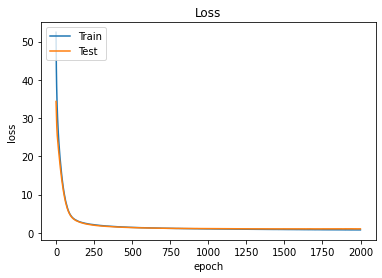

In [15]:
# Gráfica del la perdida del Modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

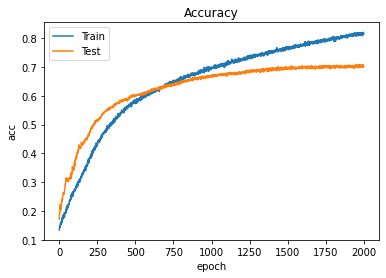

In [16]:
# Gráfica del Accuracy del Modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
from sklearn.metrics import classification_report
predictions = np.argmax(model.predict(x_testnn),axis=1)
y_test = y_test.astype(int)
report = classification_report(y_test, predictions)
print(report)

80/80 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       456
           1       0.69      0.62      0.66       372
           2       0.67      0.64      0.66       414
           3       0.67      0.74      0.71       410
           4       0.76      0.73      0.75       383
           5       0.67      0.75      0.71       403
           6       0.91      0.91      0.91       121

    accuracy                           0.73      2559
   macro avg       0.75      0.74      0.74      2559
weighted avg       0.73      0.73      0.73      2559



In [18]:
y_test

array([5, 0, 5, ..., 1, 2, 1])

In [19]:
predictions

array([5, 0, 5, ..., 2, 2, 6])

## Matriz de confusion

In [20]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions)

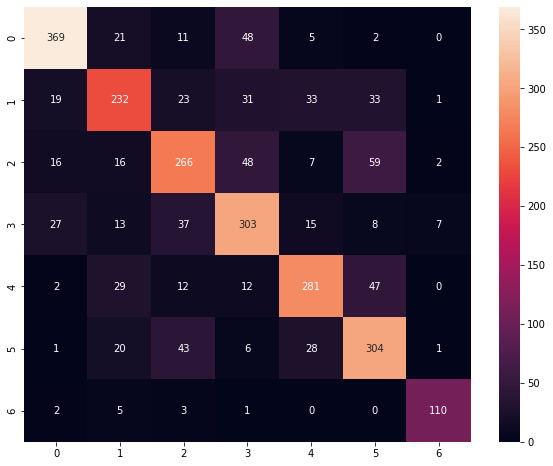

In [21]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d");

In [22]:
# # Descomentar si se desea guardar el modelo
# import pickle
# pickle.dump(model, open('models/NN_model.model','wb'))